In [1]:
## Python packages - you may have to pip install sqlalchemy, sqlalchemy_utils, and psycopg2.
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd

import re # to access database details in a file
import time # to time how long queries and processes take
import matplotlib.pyplot as plt
from datetime import datetime # to manipulate dates

% matplotlib inline

In [2]:
path='/Users/brianna/Documents/WL_DBdeets/'

In [3]:
def connect_db(which_db):
    # Grab the details from a text file for how to access the database
    db_file = open(path+which_db+'DBdeets.txt','r')
    db_deets = db_file.read()

    dbname=re.findall('dbname=(\S+)',db_deets)
    username=re.findall('username=(\S+)',db_deets)
    hostname=re.findall('hostname=(\S+)',db_deets)
    portname=re.findall('portname=(\S+)',db_deets)
    pw=re.findall('pw=(\S+)',db_deets)
    
    # Connect to the database.  (If you can't, jump out and give a polite notice!)
    con = None
    try:
        con = psycopg2.connect(database = dbname[0], 
                               user = username[0], 
                               host = hostname[0], 
                               port = portname[0], 
                               password = pw[0])
        # Set up a cursor.  (Anytime you get an error with the cursor, you have to reset the 
        # connection with it)
        cur=con.cursor()
        print('I connected to the '+which_db+' database!!')
    except:
        print('Unable to connect to '+which_db+' database :(')
    
    db_file.close()
    
    return  con, cur

In [4]:
# Access the 'events' database.
conE, curE = connect_db('evnt')

# Access the 'transactions' database.
conT, curT = connect_db('trns')

I connected to the evnt database!!
I connected to the trns database!!


# Merge the two databases by finding the key that translates their ids

In [5]:
# Make a list of everyone who's signed up (AKA had a sign-up event)

starttime=time.time()

sql_query="""
    select user_id, u_email, event_time
    from app131567.signed_up
"""

query_result = pd.read_sql_query(sql_query,conE)

print(time.time()-starttime)

df_Ecodes=query_result.iloc[:]

14.7650129795


18139
17236
13092
Duplicate emails: 4598
Null emails: 4599
13540


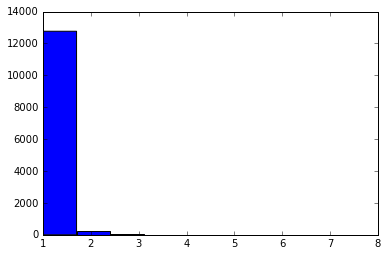

In [28]:


#df_signups.head
print(len(df_Ecodes[:]['user_id']))
print(len(df_Ecodes[:]['user_id'].unique()))
print(len(df_Ecodes[:]['u_email'].unique()))

# Print the user_id and event_times of user_ids that are listed more than once.
num_nullEmail = len(df_Ecodes.u_email[df_Ecodes.u_email.isnull()])
num_DupEmail = len(df_Ecodes.u_email[df_Ecodes[:]['u_email'].duplicated() & df_Ecodes.u_email.isnull()])
#print(df_Ecodes.user_id[df_Ecodes[:]['user_id'].duplicated()])
#print(df_Ecodes.event_time[df_Ecodes[:]['user_id'].duplicated()])
print('Duplicate emails: '+str(num_DupEmail))
print('Null emails: '+str(num_nullEmail))

#type(df_Ecodes.groupby(['u_email']).size()[:])
plt.hist(df_Ecodes.groupby(['u_email']).size()[:])
print(sum(df_Ecodes.groupby(['u_email']).size()[:]))

In [7]:
# Before we can save these data of when people signed up, we have to match with the user_id 
# of the transactional database.  I'll use the email addresses to make a key to combine the 
# user_id's from both databases.

starttime=time.time()

sql_query="""
select id, primary_email 
from users
"""

query_result = pd.read_sql_query(sql_query,conT)

print(time.time()-starttime)

df_Tcodes=query_result.iloc[:]

2.2441880703


37632
37632
37423


(array([  3.74060000e+04,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.60000000e+01]),
 array([ 1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ]),
 <a list of 10 Patch objects>)

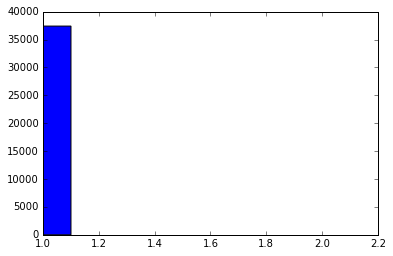

In [9]:

print(len(df_Tcodes[:]['id']))
print(len(df_Tcodes[:]['id'].unique()))
print(len(df_Tcodes[:]['primary_email'].unique()))

df_Tcodes.groupby(['primary_email']).size()
plt.hist(df_Tcodes.groupby(['primary_email']).size()[:])
#df_allmtngs.groupby(['user_id']).size()

In [43]:
# Ok, just make sure that entries in df_Tcodes.id are also in df_Ecodes.user_id
for id in df_Tcodes[1:10].id.unique():
    print(id)
    print(df_Ecodes.user_id[df_Ecodes.user_id == id])

55baceab95872f1da19e7609
5847    55baceab95872f1da19e7609
Name: user_id, dtype: object
555ab1bb681e8c2e4c569a4c
5929    555ab1bb681e8c2e4c569a4c
Name: user_id, dtype: object
561bad0f622164596e1f5823
13741    561bad0f622164596e1f5823
Name: user_id, dtype: object
55b2cf75ed78871c60a8abc4
8588    55b2cf75ed78871c60a8abc4
Name: user_id, dtype: object
55e5c8975238935663856a8d
11514    55e5c8975238935663856a8d
Name: user_id, dtype: object
560c252b5ef9fc6cc5015389
11129    560c252b5ef9fc6cc5015389
Name: user_id, dtype: object
566ab7e68c5b1723be34247f
1739    566ab7e68c5b1723be34247f
Name: user_id, dtype: object
563b7eef07dd5d2316bf90f1
6206    563b7eef07dd5d2316bf90f1
Name: user_id, dtype: object
562e9020a1cfec772c91502c
12725    562e9020a1cfec772c91502c
Name: user_id, dtype: object


In [48]:
keyDF = pd.merge(df_Tcodes, df_Ecodes, left_on='id', right_on='user_id', how = 'right')

In [49]:
keyDF.head

<bound method DataFrame.head of                              id                        primary_email  \
0      5604a71bb5c22b4817201d27  chanel@ancientsongdoulaservices.com   
1      55baceab95872f1da19e7609               julianduquej@gmail.com   
2      555ab1bb681e8c2e4c569a4c               jon@generalsensing.com   
3      561bad0f622164596e1f5823                    lmfmouwe@avans.nl   
4      55b2cf75ed78871c60a8abc4                     erin@book-md.com   
5      55e5c8975238935663856a8d                     robyn@yoco.co.za   
6      560c252b5ef9fc6cc5015389                   kdarrah@bisdtx.org   
7      566ab7e68c5b1723be34247f           jfair1@jaguarlandrover.com   
8      563b7eef07dd5d2316bf90f1        a.arbiser@pardesgrammar.co.uk   
9      562e9020a1cfec772c91502c               deirdre@sumdigital.com   
10     557ee41c3297d3f08dee079c                       kyleh@hzdg.com   
11     557ee41c3297d3f08dee079c                       kyleh@hzdg.com   
12     557ee41c3297d3f08dee079c 

In [6]:
# Let's look at number of meetings and user_id for events within the past 7 days
# GROUP BY user ID!
# This took 250 seconds (~4 min) to run over the past 7 days

starttime=time.time()

sql_query="""
select distinct c.user_id, count(e.time_range) num_meetings
from users u
join 
    calendars c
on
    u.id = c.user_id
left outer join 
    events e 
on 
    e.calendar_id = c.id
where lower(e.time_range) between (current_date - INTERVAL '7 days') and current_date
and json_array_length(e.attendees) > 0
group by c.user_id
"""

query_result = pd.read_sql_query(sql_query,conT)

print(time.time()-starttime)

250.074972868


In [15]:
df_allevts=query_result.iloc[:]
df_allevts.columns

AttributeError: 'DataFrame' object has no attribute 'num_attendees'

In [16]:
print(len(df_allevts[:]['user_id'].unique()))
print(len(df_allevts[:]['user_id']))

df_allevts[1:10]['user_id']

18201
310323


1    55a96f3a88d12f25e28c3a05
2    5626c4e48a7fb211d2a833a4
3    55e8c78a8ed8bb343d3d998c
4    5665b492afd3c65089b0b1a6
5    54dd311e98a41d404cf5f76f
6    55f03cdb8e41046db9c9c60d
7    554290e7c164865117e00eb4
8    55d4b90f51783604841a24cf
9    551ad1fd9283a553dac3a020
Name: user_id, dtype: object

In [ ]:
# Ok, this is just to keep the dataframe that I made with all of the individual events per 
# person (before I subset into meetings with other people.)
events = meetings


In [ ]:
# Find the number of meetings that each user has had in the amount of time specified in the SQL query
# First just do a groupby command over a subset of the data
print(df_allevts.columns)
print(df.columns)
df.groupby(['user_id']).agg(['meeting_start'])
#df[['user_id', 'num_attendees']].groupby(['user_id']).agg(['num_attendees'])

In [ ]:
# Make a dict of user_id paired with number of meetings

#meeting_count = dict()
meeting_count = pd.DataFrame(columns=['user_id', 'num_meetings'])

i=0
for line in df.groupby('user_id'):
#    meeting_count[line[0]] = len(line[1])
    #meeting_count.user_id[i]=line[0]
    #meeting_count.num_meetings[i]=len(line[1])
    if i < 1:
        print(line)
    i +=1

In [ ]:
df.groupby('user_id')

In [ ]:
x = df.groupby('user_id')
type(x)

df.groupby('').size().plot(kind='bar')

In [ ]:
for user in meetings.user_id:
    #print(user)
    meetings.num_meetings[meetings.user_id == user]=len(df[df['user_id'] == user])
    
#print(time.time()-starttime)
#meetings.head

In [ ]:
plt.figure(figsize=(20,10))
#plt.legend('Number of attendees at each meeting (people that signed up in the past 1 day)', fontsize=25)

meetings.groupby('num_meetings').size().plot(kind='bar')
plt.savefig('NumberOfMeetingsInPastWeekAllUsers.png')

In [ ]:
# All calendar events for users registering in past 7 days
# (This takes a few minutes to run)

sql_query="""
select u.primary_email, c.user_id, c.source_id, c.type, c.active, c.title, 
json_array_length(e.attendees) attendee_count, e.time_range, e.title
from users u
join     
    calendars c
on     
    u.id = c.user_id
left outer join 
    events e 
on 
    e.calendar_id = c.id
    and lower(e.time_range) between (current_date - INTERVAL '7 days') and current_date
where u.id = c.user_id
and u.created_at > current_date - INTERVAL '7 days'
and json_array_length(e.attendees) > 0
"""

query_result = pd.read_sql_query(sql_query,conT)

In [ ]:
df=query_result.iloc[:]

In [ ]:
df.columns

In [ ]:
plt.figure(figsize=(20,10))
#plt.legend('Number of attendees at each meeting (people that signed up in the past 1 day)', fontsize=25)

df.groupby('attendee_count').size().plot(kind='bar')

In [ ]:
for time_range in query_result.iloc[1:5]['user_id']:
    print(time_range)

In [ ]:
# People from companies viewing a meeting details page by week
# event data

# Select 4 columns of data (company, date, number of users, and number of events)
# from the table which holds data from events where people viewed the meeting_details
# page.  Then group the data by week and company name
sql_query="""
select 
    u_company_name as company,
    date_trunc('week', event_time)::date as week,
    count(distinct user_id) as users, 
    count(*) as events
from app131567.viewed_meeting_details_page
group by date_trunc('week', event_time)::date, u_company_name
order by company, week asc
"""


query_result = pd.read_sql_query(sql_query,conE)

In [ ]:
#plt.scatter(df.users[df.company=='15five.com'],df.events[df.company=='15five.com'] )


In [ ]:
# People from companies viewing a meeting details page by week
# event data

# Select 2 columns of data (date, number of unique users)
# from the table which holds data from events where people viewed the meeting_details
# page.  Then group the data by week.

sql_query="""
select 
    date_trunc('week', event_time)::date as week,
    count(distinct user_id) as users
from app131567.viewed_meeting_details_page
group by date_trunc('week', event_time)::date
order by week asc
"""

query_result = pd.read_sql_query(sql_query,conE)

df = query_result.iloc[:]

In [ ]:
date_cutoff = datetime.strptime('2015-08-02', '%Y-%m-%d').date()

xlabel='Week'
ylabel='Number of Users logged in (at least once)'
plt.figure(figsize=(20,10))
plt.xlabel(xlabel, fontsize=25)
plt.ylabel(ylabel, fontsize=25)

# histogram of count of weeks
#df.groupby('week').size().plot(kind='bar')

plt.plot(df.week[df.week > date_cutoff], df.users[df.week > date_cutoff])
plt.plot(df.week, df.users)
#plt.scatter(query_result.iloc[:]['users'], query_result.iloc[:]['events'], color="red")
#plt.scatter(df.users[df.users < 500], df.events[df.users < 500], color="red")
#plt.scatter(df.users[df.users < 100], df.events[df.users < 100], color="red")
#plt.scatter(df.users[df.users > 1500], df.events[df.users > 1500], color="red")
#plt.scatter(df.users, df.events, color="red")

plt.savefig(path+xlabel+'BY'+ylabel+'.png')


In [ ]:
# Trailing 7 day calendar events for a specific user id

# sql_query="""
# select c.user_id, c.source_id, c.type, c.active, c.title, e.* 
# from calendars c, events e
# where c.id = e.calendar_id
# and c.user_id = '54d14f9453832673fdd7c29c'
# and lower(time_range) between (current_date - INTERVAL '7 days') and current_date
# """

# calendars variables:
# id, type, source_id, active, raw, created_at, updated_at, sync, legacy, last_event_sync_at, last_calendar_sync_at,
# deleted_at, user_id, needs_sync, integration_id, title

# event variables:
# id, type, source_id, calendar_id, raw, created_at, updated_at, time_range, legacy, ignored, title, location, 
# source_url, attendees, global_id, recurring_event_id

sql_query="""
select e.*
from calendars c, events e
where c.id = e.calendar_id
and c.user_id = '54d14f9453832673fdd7c29c'
and lower(time_range) between (current_date - INTERVAL '7 days') and current_date
"""

query_result = pd.read_sql_query(sql_query,conT)